<h3><a href="https://pollytikhonova.github.io/bioinformatics_homeworks/Medicine_modelling"><img src="https://pollytikhonova.github.io/bioinformatics_homeworks/GitHub-Mark-32px.png" alt="Вернуться в репозиторий" title="Вернуться в репозиторий" style="max-width:100%;  display: inline-block; margin-right: 10px;"></a>
Tikhonova Polina. Homework 9. </h3>

In [1]:
import os
import urllib2
from bs4 import BeautifulSoup
import requests

import IPython.display
import ipywidgets
from IPython.display import display,display_svg,SVG,Image, HTML,IFrame
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import __main__
__main__.pymol_argv = ['pymol','-qc'] # Pymol: quiet and no GUI
from time import sleep
import pymol
pymol.finish_launching()

### Download files from kodomo

In [5]:
path = 'http://kodomo.cmm.msu.ru/~golovin/bilayer/'
response = urllib2.urlopen(path)
html = response.read()

soup = BeautifulSoup(html, "html5lib")
for link in soup.find_all('a'):
    if '.' in link.get('href'):
        file_response = urllib2.urlopen(path+link.get('href'))
        html = file_response.read()
        with open(link.get('href'), 'w') as f:
            f.write(html)

### Modelling

In [6]:
!genconf -f dppc.gro -o b_64.gro -nbox 4 4 4

                         :-)  G  R  O  M  A  C  S  (-:

                              S  C  A  M  O  R  G

                            :-)  VERSION 4.5.5  (-:

        Written by Emile Apol, Rossen Apostolov, Herman J.C. Berendsen,
      Aldert van Buuren, Pär Bjelkmar, Rudi van Drunen, Anton Feenstra, 
        Gerrit Groenhof, Peter Kasson, Per Larsson, Pieter Meulenhoff, 
           Teemu Murtola, Szilard Pall, Sander Pronk, Roland Schulz, 
                Michael Shirts, Alfons Sijbers, Peter Tieleman,

               Berk Hess, David van der Spoel, and Erik Lindahl.

       Copyright (c) 1991-2000, University of Groningen, The Netherlands.
            Copyright (c) 2001-2010, The GROMACS development team at
        Uppsala University & The Royal Institute of Technology, Sweden.
            check out http://www.gromacs.org for more information.

         This program is free software; you can redistribute it and/or
          modify it under the terms of the GNU General Public Licens

### Convert to pdb

In [8]:
!editconf -f dppc.gro -o dppc.pdb
!editconf -f b_64.gro -o b_64.pdb

                         :-)  G  R  O  M  A  C  S  (-:

                              S  C  A  M  O  R  G

                            :-)  VERSION 4.5.5  (-:

        Written by Emile Apol, Rossen Apostolov, Herman J.C. Berendsen,
      Aldert van Buuren, Pär Bjelkmar, Rudi van Drunen, Anton Feenstra, 
        Gerrit Groenhof, Peter Kasson, Per Larsson, Pieter Meulenhoff, 
           Teemu Murtola, Szilard Pall, Sander Pronk, Roland Schulz, 
                Michael Shirts, Alfons Sijbers, Peter Tieleman,

               Berk Hess, David van der Spoel, and Erik Lindahl.

       Copyright (c) 1991-2000, University of Groningen, The Netherlands.
            Copyright (c) 2001-2010, The GROMACS development team at
        Uppsala University & The Royal Institute of Technology, Sweden.
            check out http://www.gromacs.org for more information.

         This program is free software; you can redistribute it and/or
          modify it under the terms of the GNU General Public Licens

### View dppc

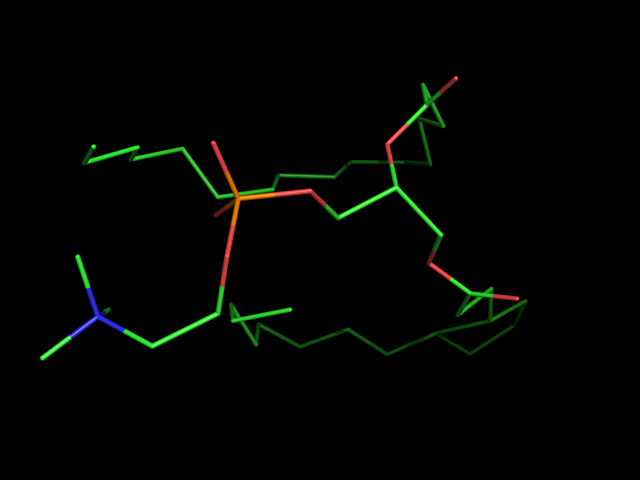

In [12]:
pymol.cmd.reinitialize()
pymol.cmd.do('''
    load dppc.pdb   
    png dppc.png
''')
    # Desired pymol commands here to produce and save figures
sleep(2.5) # (in seconds)
Image(filename='dppc.png')

### View b_64

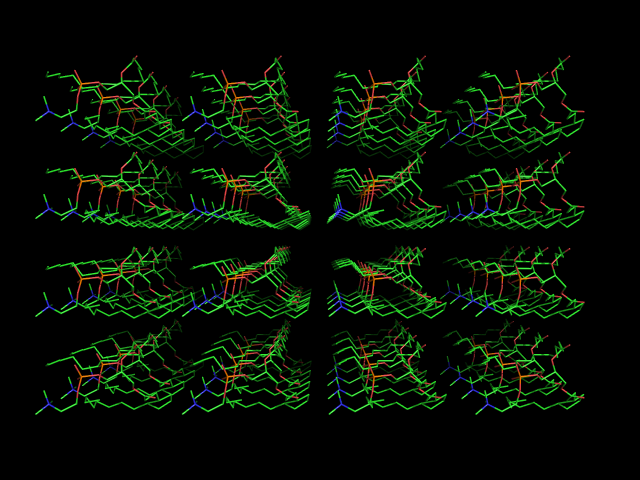

In [16]:
pymol.cmd.reinitialize()
pymol.cmd.do('''
    load b_64.pdb   
    png b_64.png
''')
    # Desired pymol commands here to produce and save figures
sleep(2.5) # (in seconds)
Image(filename='b_64.png')

### Edit b.top

In [25]:
with open('b.top') as f:
    b_top = f.read()
b_top_lines = b_top.split('\n')
b_top_lines[-2] = 'DPPC    64'
with open('b.top','w') as f:
    f.write('\n'.join(b_top_lines))

### Make an indent

In [27]:
%%bash
editconf -f b_64.gro -o b_ec -d 0.5 

### System geometry optimization

In [36]:
%%bash
grompp -f em -c b_ec -p b -o b_em -maxwarn 2 -v
mdrun -deffnm b_em -v > force.log

Вообще, по какой-то причине информацию о изменении силы я могу найти только если запущу последнюю команду в терминале. 
И в force.log эта инофрмация почему-то не сохраняется. Поэтому я просто руками сохранила нужные строчки в force.log.

In [45]:
forces = []
with open('force.log') as f:
    for line in f:
        if 'Dmax' in line:
  #          print(line)
            forces.append((re.split(pattern='Step=   |, Dmax= | nm, Epot= | Fmax= |, atom= |\n', string=line)[1:-1]))
forces_log = pd.DataFrame(forces,columns=['Step', 'Dmax', 'Epot', 'Fmax', 'atom'])      
print('''Таким образом, начальное значение силы = %.2f\nКонечное значение = %.2f
Видим, что сила существенно уменьшилась.
Ниже полная таблица изменений силы.'''%
      (float(forces_log['Fmax'][0]), float(list(forces_log['Fmax'])[-1])))
forces_log

Таким образом, начальное значение силы = 437970.00
Конечное значение = 616.89
Видим, что сила существенно уменьшилась.
Ниже полная таблица изменений силы.


,Step,Dmax,Epot,Fmax,atom
0,0,2.0e-02,4.74007e+05,4.37970e+05,1842
1,1,2.0e-02,7.19293e+04,3.57933e+04,2588
2,2,2.4e-02,3.56795e+04,9.52568e+03,2993
3,3,2.9e-02,3.46459e+04,1.50508e+04,2992
4,4,3.5e-02,2.99879e+04,1.37059e+04,2592
5,6,2.1e-02,1.30782e+04,4.02791e+03,1342
6,9,6.2e-03,1.04672e+04,1.87751e+03,2392
7,10,7.5e-03,1.02199e+04,3.76147e+03,1792
8,11,9.0e-03,1.01147e+04,4.34365e+03,2392
9,13,5.4e-03,7.19423e+03,1.91912e+03,2765


### Add water

In [46]:
!genbox -cp b_em -p b -cs spc216 -o b_s

                         :-)  G  R  O  M  A  C  S  (-:

               Giant Rising Ordinary Mutants for A Clerical Setup

                            :-)  VERSION 4.5.5  (-:

        Written by Emile Apol, Rossen Apostolov, Herman J.C. Berendsen,
      Aldert van Buuren, Pär Bjelkmar, Rudi van Drunen, Anton Feenstra, 
        Gerrit Groenhof, Peter Kasson, Per Larsson, Pieter Meulenhoff, 
           Teemu Murtola, Szilard Pall, Sander Pronk, Roland Schulz, 
                Michael Shirts, Alfons Sijbers, Peter Tieleman,

               Berk Hess, David van der Spoel, and Erik Lindahl.

       Copyright (c) 1991-2000, University of Groningen, The Netherlands.
            Copyright (c) 2001-2010, The GROMACS development team at
        Uppsala University & The Royal Institute of Technology, Sweden.
            check out http://www.gromacs.org for more information.

         This program is free software; you can redistribute it and/or
          modify it under the terms of the GNU Gener

In [47]:
%%bash
grompp -f pr -c b_s -p b -o b_pr -maxwarn 1
mdrun -deffnm b_pr -v

                         :-)  G  R  O  M  A  C  S  (-:

                   Great Red Oystrich Makes All Chemists Sane

                            :-)  VERSION 4.5.5  (-:

        Written by Emile Apol, Rossen Apostolov, Herman J.C. Berendsen,
      Aldert van Buuren, Pär Bjelkmar, Rudi van Drunen, Anton Feenstra, 
        Gerrit Groenhof, Peter Kasson, Per Larsson, Pieter Meulenhoff, 
           Teemu Murtola, Szilard Pall, Sander Pronk, Roland Schulz, 
                Michael Shirts, Alfons Sijbers, Peter Tieleman,

               Berk Hess, David van der Spoel, and Erik Lindahl.

       Copyright (c) 1991-2000, University of Groningen, The Netherlands.
            Copyright (c) 2001-2010, The GROMACS development team at
        Uppsala University & The Royal Institute of Technology, Sweden.
            check out http://www.gromacs.org for more information.

         This program is free software; you can redistribute it and/or
          modify it under the terms of the GNU General P

Option     Filename  Type         Description
------------------------------------------------------------
  -f         pr.mdp  Input        grompp input file with MD parameters
 -po      mdout.mdp  Output       grompp input file with MD parameters
  -c        b_s.gro  Input        Structure file: gro g96 pdb tpr etc.
  -r       conf.gro  Input, Opt.  Structure file: gro g96 pdb tpr etc.
 -rb       conf.gro  Input, Opt.  Structure file: gro g96 pdb tpr etc.
  -n      index.ndx  Input, Opt.  Index file
  -p          b.top  Input        Topology file
 -pp  processed.top  Output, Opt. Topology file
  -o       b_pr.tpr  Output       Run input file: tpr tpb tpa
  -t       traj.trr  Input, Opt.  Full precision trajectory: trr trj cpt
  -e       ener.edr  Input, Opt.  Energy file

Option       Type   Value   Description
------------------------------------------------------
-[no]h       bool   no      Print help info and quit
-[no]version bool   no      Print version info and quit
-nice      

In [56]:
%%bash
editconf -f b_pr.gro -o b_pr.pdb
editconf -f b_s.gro -o b_s.pdb

### View in Pymol

Объекты  b_pr и  b_s различаются как по своей структуре, так и по расположению воды.

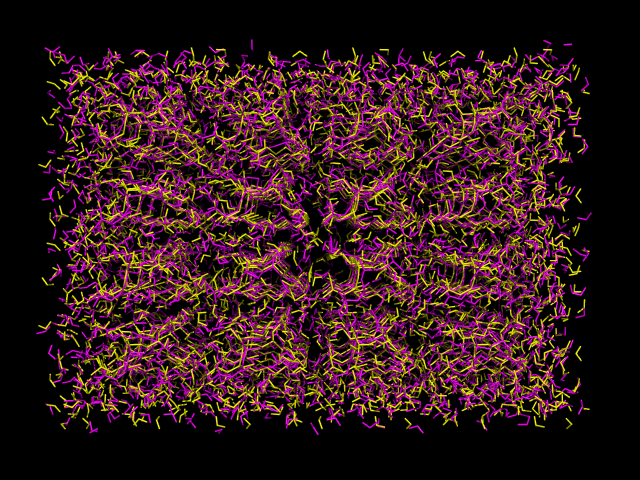

In [76]:
pymol.cmd.reinitialize()
pymol.cmd.do('''
    load b_pr.pdb   
    load b_s.pdb  
    color yellow, b_s
    color magenta, b_pr
    png general.png
''')
    # Desired pymol commands here to produce and save figures
sleep(2.5) # (in seconds)
Image(filename='general.png')

Ниже они показаны отдельно.

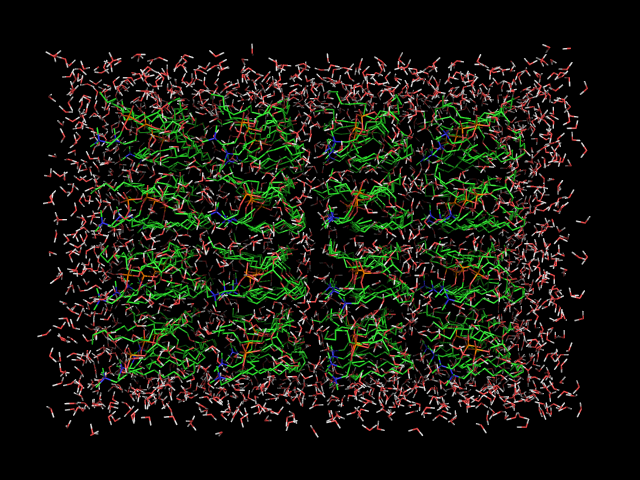

In [73]:
pymol.cmd.reinitialize()
pymol.cmd.do('''
    load b_pr.pdb   
    png b_pr.png
''')
    # Desired pymol commands here to produce and save figures
sleep(2.5) # (in seconds)
Image(filename='b_pr.png')

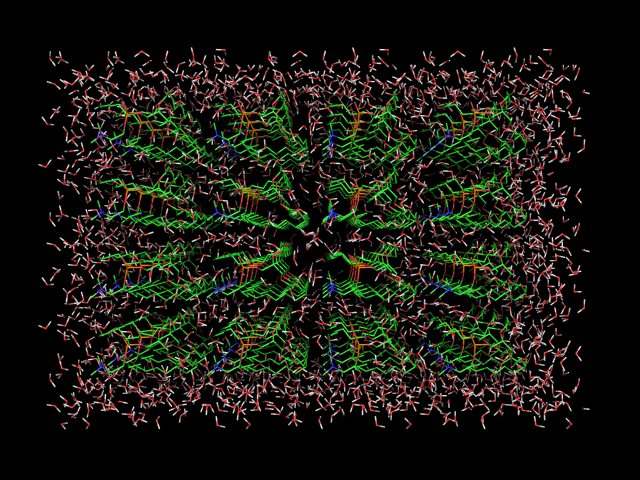

In [74]:
pymol.cmd.reinitialize()
pymol.cmd.do('''
    load b_s.pdb   
    png b_s.png
''')
    # Desired pymol commands here to produce and save figures
sleep(2.5) # (in seconds)
Image(filename='b_s.png')

### Lomonosov

В консоли...

In [ ]:
scp -r . lom:_scratch/hse/tikhonova/hw9
ssh lom
cd _scratch/hse/tikhonova/hw9
cp /home/users/golovin/progs/share/gromacs/top/residuetypes.dat .
grompp -f md -c b_pr -p b -o b_md -maxwarn 1
sbatch -n 4 -e error.log -o output.log -t 5 -p test impi /opt/ccoe/gromacs-5.0.4/build/bin/gmx_mpi mdrun -testverlet -deffnm b_md -v

Submitted batch job 1646360

In [ ]:
sbatch -N1 --ntasks-per-node=2 -e error-gpu.log -o output.log -t 350 -p gpu impi /opt/ccoe/gromacs-5.0.4/build/bin/gmx_mpi mdrun -testverlet -deffnm  b_md -v

Submitted batch job 1646365

#### Analysis

In [ ]:
# куча каких-то лишних непонятных связей
trjconv -f b_md.xtc -s b_md.tpr -o b_pbc_1.pdb -skip 20  #DPPC

In [3]:
IFrame(src="trajectories1.html", width=900, height=700)

In [ ]:
trjconv -f b_md.xtc -s b_md.tpr -o b_pbc_1.pdb -skip 20 -pbc mol

К сожалению положение камеры и приближение на js я настроить не смогла. Так что обзор придется каждый раз устанавливать  помощью мышки.

In [5]:
IFrame(src="trajectories.html", width=900, height=700)

Структура рушится сразу, примерно к 50 фрейму (t = 24500) она становится уже более менее похожей на бислой. 
И к 65 фрейму (t = 32000) она уже довольно четко разделена на 2 слоя.

#### Сводная картинка из Pymol

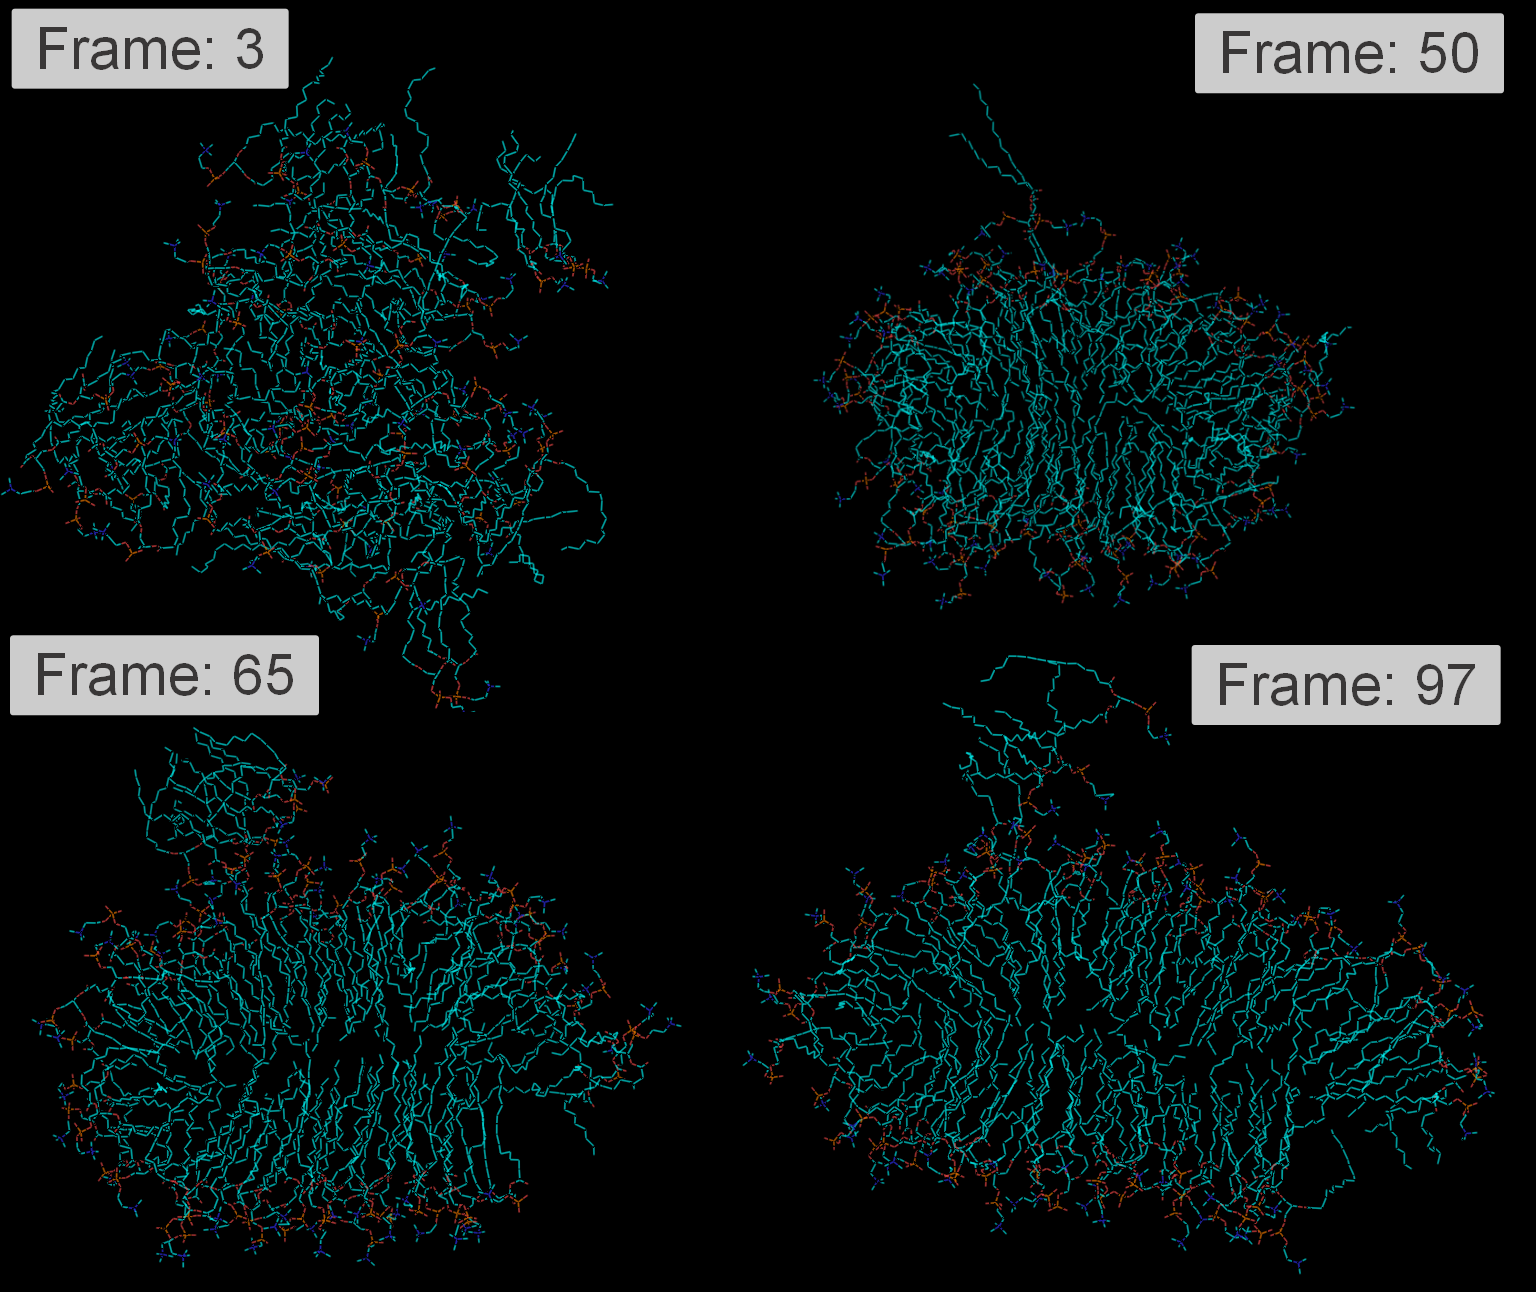

In [32]:
Image('Frames.png')

###### Определите площадь занимаемую одним липидом.

In [ ]:
g_traj -f b_md.xtc -s b_md.tpr -ob box_1.xvg

In [101]:
sizes = pd.read_csv(path+'box_1.xvg', header = None, skiprows = 24, sep='\t')
sizes = sizes[[1,2,3,4]]
sizes.columns = ['time', 'X', 'Y', 'Z']
sizes.head()

,time,X,Y,Z
0,0,6.26000,4.44300,5.77800
1,25,6.24560,4.43278,5.82278
2,50,6.20660,4.40510,5.87096
3,75,6.19381,4.39602,5.90044
4,100,6.18117,4.38705,5.92904


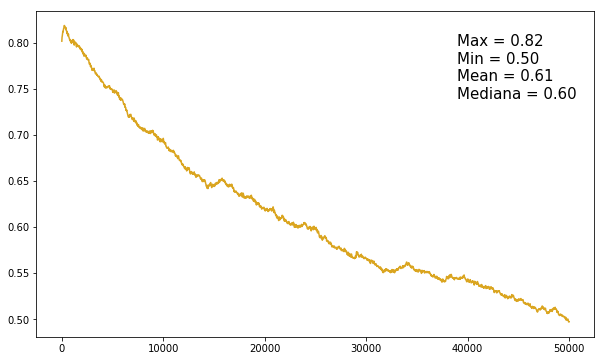

In [129]:
plt.figure(figsize=(10,6))
lip_sizes = np.array(sizes['Y'])*np.array(sizes['Z'])/32.
plt.plot(np.array(sizes['time']), lip_sizes, color='goldenrod');
plt.text(39000, 0.74, 'Max = %.2f\nMin = %.2f\nMean = %.2f\nMediana = %.2f'%(max(lip_sizes), min(lip_sizes),
                                                              np.mean(lip_sizes), np.median(lip_sizes)), fontsize=15);

Липиды становятся очень компактными.

##### Определите изменение гидрофобной и гидрофильной поверхности в ходе самосборки

In [ ]:
g_sas -f b_md.xtc -s b_md.tpr -o sas_b.xvg -dt 100

In [89]:
sizes = pd.read_csv(path+'sas_b.xvg', header = None, skiprows = 22, sep='\s+')
sizes = sizes[[0,1,2]]
sizes.columns = ['time', 'Hydrophobic', 'Hydrophilic']
sizes.head()

,time,Hydrophobic,Hydrophilic
0,0,206.710,135.376
1,100,190.593,150.694
2,200,167.211,155.765
3,300,154.562,159.593
4,400,152.911,162.379


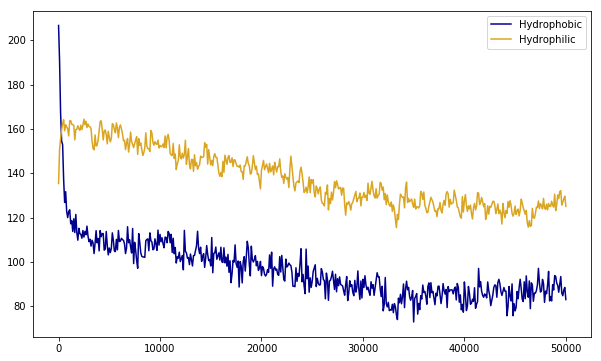

In [90]:
plt.figure(figsize=(10,6))
plt.plot(np.array(sizes['time']), sizes['Hydrophobic'], label='Hydrophobic', color='darkblue');
plt.plot(np.array(sizes['time']), sizes['Hydrophilic'], label='Hydrophilic', color='goldenrod');
plt.legend();

Резко снижается площадь гидрофобной поверхности, доступной растворителю, что в общем-то логично. И в целом площади поверхностей убывают с течением времени, что свидетельствует о снижении энергии структуры -> происходит самосборка липидного слоя.

##### Оценка фазового состояния бифильных молекул

In [ ]:
g_order -s b_md -f b_md.xtc -o ord_end.xvg -n sn1.ndx -b 45000 -d X
g_order -s b_md -f b_md.xtc -o ord_start.xvg -n sn1.ndx -e 5000 -d X

In [104]:
start = pd.read_csv(path+'ord_start.xvg', header = None, skiprows = 12, sep='\s+')
end = pd.read_csv(path+'ord_end.xvg', header = None, skiprows = 12, sep='\s+')

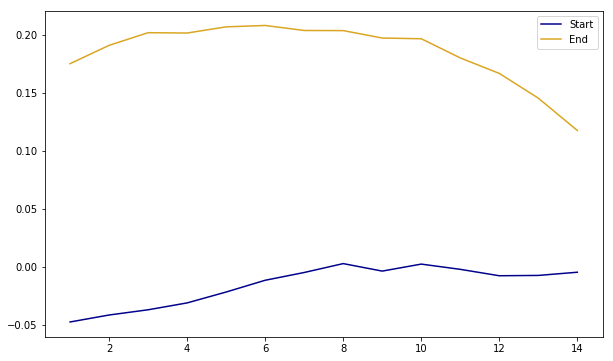

In [105]:
plt.figure(figsize=(10,6))
plt.plot(np.array(start[0]), start[3], label='Start', color='darkblue');
plt.plot(np.array(end[0]), end[3], label='End', color='goldenrod');
plt.legend();

Видно, что в конце сборки атомы намного более упорядочены.

### Save to Html

In [6]:
import subprocess
converted = subprocess.call(["jupyter-nbconvert", '--to', 'html',"Tikhonova. HW9.ipynb"], shell=False)
if converted==0:
    print 'Your ipynb-file was sucessfully converted!'
else:
    print 'Smth went wrong. for instance, check the filename...'
show_link = '<a href="%s" target="_blank">You can download it here!</a>'%('Tikhonova. HW9.html')
display(HTML(show_link))

#### <a href='Tikhonova. HW9.ipynb'> Download this notebook </a>